## Targeted Classifier Experiment


In [1]:
%load_ext autoreload
%autoreload 2

import sklearn
import json


with open("../../data/dataset.json") as f:
    data = json.load(f)


## Exploratorio

In [2]:
def is_mixed(instance):
    return len(set(instance["labels"].values())) >= 2

len([x for x in data if is_mixed(x)]), len(data)

(160, 1930)

In [3]:
[x for x in data if is_mixed(x)]

[{'titulo': 'Entre el milagro de Macri y la grieta del peronismo',
  'id': 39,
  'labels': {'Macri': 'POS', 'peronismo': 'NEG'}},
 {'titulo': 'Tras plantar a Macri, Acevedo recibe a Alberto Fernández en la UIA',
  'id': 951,
  'labels': {'Macri': 'NEG', 'Alberto Fernández': 'POS'}},
 {'titulo': 'Alberto Fernández rechazó las promesas de Macri: “Lo único que hizo fue sumergir en la pobreza a 5 millones de argentinos”',
  'id': 1265,
  'labels': {'Macri': 'NEG', 'Alberto Fernández': 'POS'}},
 {'titulo': 'Miguel Ángel Pichetto en el acto a favor de Macri: “Si gana Fernández gana Cristina, y va a gobernar ella”',
  'id': 1282,
  'labels': {'Miguel Ángel Pichetto': 'POS',
   'Macri': 'POS',
   'Fernández': 'NEG',
   'Cristina': 'NEG'}},
 {'titulo': 'Roberto Lavagna criticó el discurso de Mauricio Macri: “No es cierto, hoy no estamos mejor para empezar a crecer”',
  'id': 1286,
  'labels': {'Roberto Lavagna': 'POS', 'Mauricio Macri': 'NEG'}},
 {'titulo': 'La sugerencia de Cristina Kirchner a

In [4]:

len([x for x in data if len(x["labels"]) > 1]), len(data)

(396, 1930)

In [5]:
import pandas as pd

label2id = {
    "NEG": 0,
    "NEU": 1,
    "POS": 2
}

id2label = {v:k for k, v in label2id.items()}

def build_auxiliary_sentence(target):
    return f"¿Qué pensás de {target}?"

def build_df(data):
    return pd.DataFrame([{
        "id": x["id"],
        "sentence": x["titulo"],
        "target": target,
        "auxiliary_sentence": build_auxiliary_sentence(target),
        "label": label2id[label],
    } for x in data for (target, label) in x["labels"].items()])

Bien, está dentro de todo equilibrado

## Train test split

Lo hago sobre el dataset. No sería mejor hacerlo por oraciones?

In [6]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, random_state=2021, stratify=[len(x["labels"]) for x in data])

train_data, dev_data = train_test_split(train_data, random_state=2021, stratify=[len(x["labels"]) for x in train_data])

len(train_data), len(dev_data), len(test_data)

(1085, 362, 483)

## Armar dataset

In [7]:
from datasets import Dataset, Value, ClassLabel, Features

train_df = build_df(train_data)
dev_df = build_df(dev_data)
test_df = build_df(test_data)

features = Features({
    'sentence': Value('string'),
    'auxiliary_sentence': Value('string'),
    'label': ClassLabel(num_classes=3, names=["neg", "neu", "pos"])
})

columns = ["sentence", "auxiliary_sentence", "label"]

train_dataset = Dataset.from_pandas(train_df[columns], features=features)
dev_dataset = Dataset.from_pandas(dev_df[columns], features=features)
test_dataset = Dataset.from_pandas(test_df[columns], features=features)

In [8]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_name = 'dccuchile/bert-base-spanish-wwm-uncased'

model = AutoModelForSequenceClassification.from_pretrained(
    model_name, return_dict=True, num_labels=len(id2label)
)

model.config.id2label = id2label
model.config.label2id = label2id

tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer.model_max_length = 128


Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuc

In [9]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

model = model.to(device)

In [10]:
def tokenize(batch):
    return tokenizer(batch['sentence'], batch['auxiliary_sentence'], padding='max_length', truncation=True)

batch_size = 16
eval_batch_size = 8

train_dataset = train_dataset.map(tokenize, batched=True, batch_size=batch_size)
dev_dataset = dev_dataset.map(tokenize, batched=True, batch_size=eval_batch_size)
test_dataset = test_dataset.map(tokenize, batched=True, batch_size=eval_batch_size)

(array([ 20., 124., 218., 392., 257., 192.,  98.,  23.,   7.,   5.]),
 array([16. , 19.6, 23.2, 26.8, 30.4, 34. , 37.6, 41.2, 44.8, 48.4, 52. ]),
 <BarContainer object of 10 artists>)

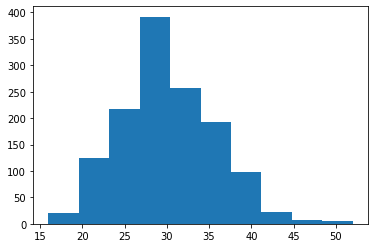

In [11]:
import matplotlib.pyplot as plt

lens = [sum(x["attention_mask"]) for x in train_dataset]


plt.hist(lens)

In [12]:
train_dataset[0].keys()

dict_keys(['attention_mask', 'auxiliary_sentence', 'input_ids', 'label', 'sentence', 'token_type_ids'])

In [13]:

def format_dataset(dataset):
    dataset = dataset.map(lambda x: {"labels": x["label"]})
    columns = ['input_ids', 'attention_mask', 'labels']
    if 'token_type_ids' in dataset.features:
        columns.append('token_type_ids')
    dataset.set_format(type='torch', columns=columns)
    return dataset

train_dataset = format_dataset(train_dataset)
dev_dataset = format_dataset(dev_dataset)
test_dataset = format_dataset(test_dataset)


In [14]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred, id2label):
    """
    Compute metrics for Trainer
    """
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    ret = {}

    f1s = []
    precs = []
    recalls = []

    for i, cat in id2label.items():
        cat_labels, cat_preds = labels == i, preds == i
        precision, recall, f1, _ = precision_recall_fscore_support(
            cat_labels, cat_preds, average='binary', zero_division=0,
        )

        f1s.append(f1)
        precs.append(precision)
        recalls.append(recall)

        ret[cat.lower()+"_f1"] = f1
        ret[cat.lower()+"_precision"] = precision
        ret[cat.lower()+"_recall"] = recall

    _, _, micro_f1, _ = precision_recall_fscore_support(
        labels, preds, average="micro"
    )
    ret["micro_f1"] = micro_f1
    ret["macro_f1"] = torch.Tensor(f1s).mean()
    ret["macro_precision"] = torch.Tensor(precs).mean()
    ret["macro_recall"] = torch.Tensor(recalls).mean()

    ret["acc"] = accuracy_score(labels, preds)

    return ret

epochs = 5
warmup_proportion = 0.10
total_steps = (epochs * len(train_dataset)) // batch_size
warmup_steps = int(warmup_proportion * total_steps)

training_args = TrainingArguments(
    output_dir='./results/',
    num_train_epochs=epochs,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=eval_batch_size,
    warmup_steps=warmup_steps,
    evaluation_strategy="epoch",
    do_eval=False,
    weight_decay=0.01,
    logging_dir='./logs',
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=lambda x: compute_metrics(x, id2label=id2label),
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
)


In [15]:
trainer.train()

Epoch,Training Loss,Validation Loss,Neg F1,Neg Precision,Neg Recall,Neu F1,Neu Precision,Neu Recall,Pos F1,Pos Precision,Pos Recall,Micro F1,Macro F1,Macro Precision,Macro Recall,Acc,Runtime,Samples Per Second
1,No log,0.892026,0.553191,0.490566,0.634146,0.352332,0.641509,0.242857,0.669880,0.596567,0.763736,0.564045,0.525134,0.576214,0.546913,0.564045,2.222500,200.229000
2,No log,0.812063,0.636364,0.721649,0.569106,0.643599,0.624161,0.664286,0.719160,0.688442,0.752747,0.674157,0.666374,0.678084,0.662046,0.674157,2.246000,198.128000
3,No log,0.909673,0.622568,0.597015,0.650407,0.577465,0.569444,0.585714,0.681948,0.712575,0.653846,0.631461,0.627327,0.626345,0.629989,0.631461,2.226500,199.863000
4,No log,1.010713,0.627451,0.606061,0.650407,0.560284,0.556338,0.564286,0.662890,0.684211,0.642857,0.620225,0.616875,0.615536,0.619183,0.620225,2.237300,198.896000
5,No log,1.079928,0.616601,0.600000,0.634146,0.573529,0.590909,0.557143,0.684932,0.683060,0.686813,0.631461,0.625021,0.624656,0.626034,0.631461,2.195500,202.684000


TrainOutput(global_step=420, training_loss=0.5399315970284598, metrics={'train_runtime': 131.7115, 'train_samples_per_second': 3.189, 'total_flos': 563573214074880.0, 'epoch': 5.0, 'init_mem_cpu_alloc_delta': 54107, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18258, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 1147671, 'train_mem_gpu_alloc_delta': 1794120704, 'train_mem_cpu_peaked_delta': 95403346, 'train_mem_gpu_peaked_delta': 1338075648})

In [16]:
trainer.evaluate(dev_dataset)

{'eval_loss': 0.8120625615119934,
 'eval_neg_f1': 0.6363636363636365,
 'eval_neg_precision': 0.7216494845360825,
 'eval_neg_recall': 0.5691056910569106,
 'eval_neu_f1': 0.643598615916955,
 'eval_neu_precision': 0.6241610738255033,
 'eval_neu_recall': 0.6642857142857143,
 'eval_pos_f1': 0.7191601049868767,
 'eval_pos_precision': 0.6884422110552764,
 'eval_pos_recall': 0.7527472527472527,
 'eval_micro_f1': 0.6741573033707865,
 'eval_macro_f1': 0.666374146938324,
 'eval_macro_precision': 0.6780841946601868,
 'eval_macro_recall': 0.6620461940765381,
 'eval_acc': 0.6741573033707865,
 'eval_runtime': 2.0032,
 'eval_samples_per_second': 222.145,
 'epoch': 5.0,
 'eval_mem_cpu_alloc_delta': 63339,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 129381,
 'eval_mem_gpu_peaked_delta': 35169792}

In [33]:
trainer.evaluate(test_dataset)

{'eval_loss': 0.7891994714736938,
 'eval_neg_f1': 0.6266666666666666,
 'eval_neg_precision': 0.706766917293233,
 'eval_neg_recall': 0.562874251497006,
 'eval_neu_f1': 0.6437994722955145,
 'eval_neu_precision': 0.6630434782608695,
 'eval_neu_recall': 0.6256410256410256,
 'eval_pos_f1': 0.7140039447731756,
 'eval_pos_precision': 0.6557971014492754,
 'eval_pos_recall': 0.7835497835497836,
 'eval_micro_f1': 0.6694772344013491,
 'eval_macro_f1': 0.6614900231361389,
 'eval_macro_precision': 0.6752025485038757,
 'eval_macro_recall': 0.657355010509491,
 'eval_acc': 0.6694772344013491,
 'eval_runtime': 5.4895,
 'eval_samples_per_second': 108.024,
 'epoch': 5.0,
 'eval_mem_cpu_alloc_delta': 70401,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 175659,
 'eval_mem_gpu_peaked_delta': 35173376}

In [17]:
model = trainer.model

In [18]:
from torch.nn import functional as F
def predict(sentence, target):
    """
    Return most likely class for the sentence
    """
    idx = torch.LongTensor(tokenizer.encode(sentence, build_auxiliary_sentence(target))).view(1, -1).to(device)
    output = model(idx)
    probs = F.softmax(output.logits, dim=1).view(-1)
    probas = {id2label[i]:probs[i].item() for i in id2label}

    return probas



In [19]:
sentence = "Gran 2020 para Messi, pero bastante malo para Cristiano Ronaldo"

targets = ["Messi", "Cristiano Ronaldo"]

for target in targets:
    print(target)
    print(predict(sentence, target))

Messi
{'NEG': 0.4997107982635498, 'NEU': 0.3756236135959625, 'POS': 0.12466559559106827}
Cristiano Ronaldo
{'NEG': 0.4292309880256653, 'NEU': 0.43124908208847046, 'POS': 0.13951994478702545}


In [20]:
sentence = "Alberto Fernández: \"El gobierno de Macri fue un desastre\""

targets = ["Alberto Fernández", "Macri"]

for target in targets:
    print(target)
    print(predict(sentence, target))

Alberto Fernández
{'NEG': 0.35269874334335327, 'NEU': 0.10879499465227127, 'POS': 0.538506269454956}
Macri
{'NEG': 0.8838524222373962, 'NEU': 0.04280024766921997, 'POS': 0.07334741204977036}


In [21]:
sentence = "Alberto Fernández: \"El gobierno de Xi Jin Ping fue un desastre\""

targets = ["Alberto Fernández", "Xi Jin Ping"]

for target in targets:
    print(target)
    print(predict(sentence, target))

Alberto Fernández
{'NEG': 0.312344491481781, 'NEU': 0.0919780433177948, 'POS': 0.5956774950027466}
Xi Jin Ping
{'NEG': 0.7606764435768127, 'NEU': 0.06632687896490097, 'POS': 0.17299677431583405}


In [22]:
sentence = "Romina Del Plá denunció el ajuste de Alberto Fernández"

targets = ["Romina del Plá", "Alberto Fernández"]

for target in targets:
    print(target)
    print(predict(sentence, target))

Romina del Plá
{'NEG': 0.045011889189481735, 'NEU': 0.5042364597320557, 'POS': 0.4507516622543335}
Alberto Fernández
{'NEG': 0.07899035513401031, 'NEU': 0.47524917125701904, 'POS': 0.4457605183124542}


In [23]:
sentence = "El Gobierno mejora la compra de vacunas"

targets = ["Gobierno"]

for target in targets:
    print(target)
    print(predict(sentence, target))

Gobierno
{'NEG': 0.07501343637704849, 'NEU': 0.3865722715854645, 'POS': 0.5384142994880676}


In [24]:
sentence = "Cristina Kirchner acusa al Gobierno de corrupción en la compra de vacunas"

targets = ["Gobierno", "Cristina Kirchner"]

for target in targets:
    print(target)
    print(predict(sentence, target))

Gobierno
{'NEG': 0.5295925140380859, 'NEU': 0.3607024550437927, 'POS': 0.10970500111579895}
Cristina Kirchner
{'NEG': 0.08262056112289429, 'NEU': 0.6355267763137817, 'POS': 0.28185272216796875}


In [25]:
sentence = "El duro comunicado de las empresas estadounidenses contra el Gobierno"

targets = ["Gobierno", "empresas estadounidenses"]

for target in targets:
    print(target)
    print(predict(sentence, target))

Gobierno
{'NEG': 0.6989187002182007, 'NEU': 0.15511062741279602, 'POS': 0.14597070217132568}
empresas estadounidenses
{'NEG': 0.6771600842475891, 'NEU': 0.15388166904449463, 'POS': 0.16895821690559387}


In [26]:
sentence = "Ultiman negociaciones para cerrar acuerdo en la Ciudad entre Vidal y Bullrich"

targets = ["Vidal", "Bullrich"]

for target in targets:
    print(target)
    print(predict(sentence, target))

Vidal
{'NEG': 0.06415514647960663, 'NEU': 0.8167628645896912, 'POS': 0.11908198893070221}
Bullrich
{'NEG': 0.06964700669050217, 'NEU': 0.8179889917373657, 'POS': 0.1123640164732933}


In [27]:
sentence = "\"Este Gobierno ha sido una lacra corrupta inmunda\" declaró Patricia Bullrich"

targets = ["Gobierno", "Bullrich"]

for target in targets:
    print(target)
    print(predict(sentence, target))

Gobierno
{'NEG': 0.30646753311157227, 'NEU': 0.39165955781936646, 'POS': 0.3018729090690613}
Bullrich
{'NEG': 0.14612184464931488, 'NEU': 0.5319282412528992, 'POS': 0.32194992899894714}


Si lo ponemos adelante, sin embargo...

Si lo ponemos adelante, sin embargo...

In [28]:
sentence = "Patricia Bullrich: \"Este Gobierno ha sido una lacra corrupta inmunda\""

targets = ["Gobierno", "Bullrich"]

for target in targets:
    print(target)
    print(predict(sentence, target))

Gobierno
{'NEG': 0.5939323306083679, 'NEU': 0.13932697474956512, 'POS': 0.26674067974090576}
Bullrich
{'NEG': 0.3324308693408966, 'NEU': 0.21696868538856506, 'POS': 0.45060041546821594}


In [29]:
sentence = "Keiko: 'Pedro Castillo es un pésimo dirigente, pero por suerte este Gobierno es lo mejor que le ha pasado a Perú'"

targets = ["Keiko", "Pedro Castillo", "Gobierno"]

for target in targets:
    print(target)
    print(predict(sentence, target))

Keiko
{'NEG': 0.08897197246551514, 'NEU': 0.26672452688217163, 'POS': 0.6443035006523132}
Pedro Castillo
{'NEG': 0.09407155215740204, 'NEU': 0.23152899742126465, 'POS': 0.6743994355201721}
Gobierno
{'NEG': 0.22579695284366608, 'NEU': 0.34013310074806213, 'POS': 0.434069961309433}


In [30]:
sentence = "El contundente mensaje de L-Gante contra Cristina Kirchner: \"A mí nadie me regaló nada\""

targets = ["L-Gante", "Cristina Kirchner"]

for target in targets:
    print(target)
    print(predict(sentence, target))


L-Gante
{'NEG': 0.7533793449401855, 'NEU': 0.07413499057292938, 'POS': 0.17248570919036865}
Cristina Kirchner
{'NEG': 0.8249387145042419, 'NEU': 0.05391930043697357, 'POS': 0.12114198505878448}


In [31]:
sentence = "Causa Maradona: Dalma y Gianinna denunciaron que quieren que Matías Morla se vaya"

targets = ["Dalma", "Gianinna", "Matías Morla"]


for target in targets:
    print(target)
    print(predict(sentence, target))

Dalma
{'NEG': 0.6444531083106995, 'NEU': 0.2641722857952118, 'POS': 0.09137461334466934}
Gianinna
{'NEG': 0.7107165455818176, 'NEU': 0.2160339504480362, 'POS': 0.07324948906898499}
Matías Morla
{'NEG': 0.7600793838500977, 'NEU': 0.14819267392158508, 'POS': 0.09172793477773666}


In [32]:
for instance in [x for x in test_data if is_mixed(x)]:
    print("="*80)
    print(instance["labels"])
    sentence = instance["titulo"]
    print(sentence)

    targets = instance["labels"]

    for target, label in targets.items():
        probas = pd.Series(predict(sentence, target))
        predicted_label = probas.index[probas.argmax()]

        if {predicted_label, label} == {"NEG", "POS"}:
            print(target)
            print(probas)
        elif predicted_label != label:
            print(target , f" era {label}, predijo {predicted_label}")
        else:
            print(target, " OK")

{'Mauricio Macri': 'NEG', 'Alberto Fernández': 'POS'}
Alberto Fernández cruzó a Mauricio Macri por la mención a San Martín: "Nada heroico hizo usted"
Mauricio Macri
NEG    0.137378
NEU    0.284304
POS    0.578318
dtype: float64
Alberto Fernández  OK
{'Mauricio Macri': 'NEU', 'Alberto Fernández': 'POS'}
Alberto Fernández le pidió a Mauricio Macri que "no libere el dólar" si pierde las elecciones
Mauricio Macri  era NEU, predijo POS
Alberto Fernández  OK
{'Miguel Pichetto': 'POS', 'Mauricio Macri': 'POS', 'Alberto Fernández': 'NEG'}
Para Miguel Pichetto, el ganador del debate fue Mauricio Macri: “Alberto Fernández fue muy agresivo y arrogante”
Miguel Pichetto
NEG    0.821401
NEU    0.085957
POS    0.092642
dtype: float64
Mauricio Macri
NEG    0.812544
NEU    0.101299
POS    0.086157
dtype: float64
Alberto Fernández  OK
{'Mauricio Macri': 'NEG', 'Alberto Fernández': 'POS'}
Alberto Fernández cruzó a Mauricio Macri por la referencia a San Martín: “Usted solo supo entregar el país al FMI, na